# Lab 04 - Interpretability

Author: Gary Marigliano, based on the work of Hector Satizabal

Date: 2018.03

## Instructions:

* Read this notebook
* Do/Answer where **TODO student** is specified
* The folder structure is like this:

```
fuzzy_systems
├── core
└── view
```

* `core` contains core classes like membership_functions, fuzzy_rules,...
* `view` contains classes used to display what the core classes do.
* Please keep this folder structure if you write additional classes.


**TODO student** Read and explore the code provided both in this folder.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from fuzzy_systems.core.linguistic_variables.linguistic_variable import LinguisticVariable
from fuzzy_systems.core.linguistic_variables.three_points_lv import ThreePointsLV
from fuzzy_systems.core.membership_functions.lin_piece_wise_mf import LinPWMF
from fuzzy_systems.core.membership_functions.trap_mf import TrapMF
from fuzzy_systems.core.rules.fuzzy_rule import FuzzyRule, Antecedent, Consequent
from fuzzy_systems.core.fis.fis import FIS, OR_max, AND_min, MIN, COA_func

from fuzzy_systems.view.lv_viewer import LinguisticVariableViewer
from fuzzy_systems.view.fis_viewer import FISViewer
from fuzzy_systems.view.fis_surface import show_surface

## Introduction

In this lab we will look at the interpretability aspect of the fuzzy systems. Indeed, having a FIS that describes accurately a problem is good but having a FIS that is built with interpretability in mind is better.

As you have seen in the lectures, the fuzzy systems are grey-box models meaning that you can "read" them as a human and try to understand how they perform their decisions. As a human you cannot understand a too complex fuzzy system (e.g. too much rules, too much variables per rule, too much linguistic labels per linguistic variables,...).

The main idea here is to add constraints on how to build a fuzzy system. Those constraints will lead to a better interpretability with a possible loss of accuracy i.e. the "famous" **performance-interpretability trade-off**


## Semantic criteria

In this section you will be asked a few questions about the semantic criteria. For each linguistic variable (LV) one or more *interpretability mistake* have been made. Your job is to fix them and explain what was the mistake(s). **There is at least 1 mistake per linguistic variable and it should be pretty obvious which mistake(s) have been made**.

**For example**, let's imagine a LV with 1000 linguistic labels (very very very low, very very low, very low, low, ...). As an answer you could write something like: 
* The interpretability mistake here is too much linguistic labels (or "Number of elements" as written in the slides). 
* The fix here is to rewrite this LV with, let's say 4 linguistic labels (e.g. very low, low, medium and high)
* The justification is it is humanly impossible to feel/interpret the difference between "very very low" and "very low"

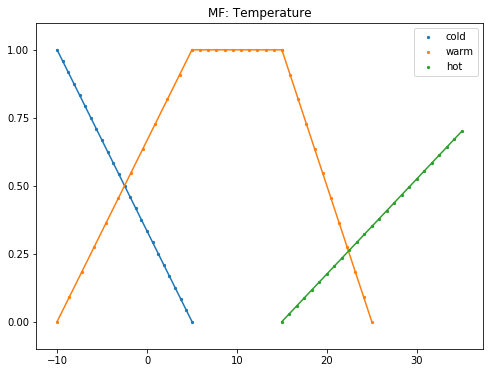

In [3]:
lv_ex1 = LinguisticVariable(name="Temperature", ling_values_dict={
    "cold": LinPWMF([-10, 1], [5, 0]),
    "warm": TrapMF(p0=-10, p1=5, p2=15, p3=25),
    "hot": LinPWMF([15, 0], [35, 0.7])
})

LinguisticVariableViewer(lv_ex1).show()

**TODO student** Knowing that the LV represents a temperature in celsius, 
* cite the interpretability mistake(s) made in the LV
* modify a copy of the LV to fix the problem(s) and justify your fix in few words.

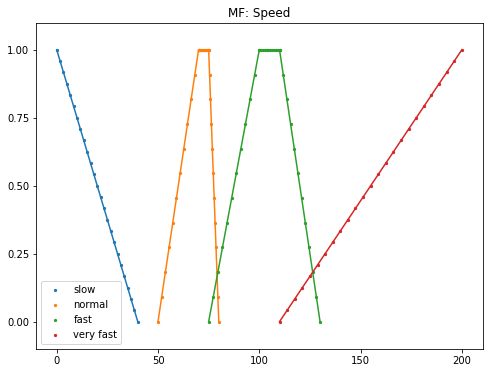

In [4]:
lv_ex2 = LinguisticVariable(name="Speed", ling_values_dict={
    "slow": LinPWMF([0, 1], [40, 0]),
    "normal": TrapMF(p0=50, p1=70, p2=75, p3=80),
    "fast": TrapMF(p0=75, p1=100, p2=110, p3=130),
    "very fast": LinPWMF([110, 0], [200, 1])
})

LinguisticVariableViewer(lv_ex2).show()

**TODO student** Knowing that the LV above represents a speed in km/h, 
* cite the interpretability mistake(s) made in the LV
* modify a copy of the LV to fix the problem(s) and justify your fix in few words.

### Wrap-up

Remember `ThreePointsLV` and `TwoPointsLV` from a previous lab ?

In [5]:
!pygmentize fuzzy_systems/core/linguistic_variables/three_points_lv.py

from fuzzy_systems.core.linguistic_variables.linguistic_variable import LinguisticVariable
from fuzzy_systems.core.membership_functions.lin_piece_wise_mf import LinPWMF


class ThreePointsLV(LinguisticVariable):
    """
    Syntactic sugar for simplified linguistic variable with only 3 points (p1,
    p2 and p3) and fixed labels ("low", "medium" and "high").


      ^
      | low      medium           high
    1 |XXXXX       X          XXXXXXXXXXXX
      |     X     X  X       XX
      |      X   X    X    XX
      |       X X      XX X
      |       XX        XXX
      |      X  X     XX   XX
      |     X    X XX       XX
      |    X       X          XX
    0 +-------------------------------------->
           p1     p2          p3


    """

    def __init__(self, name, p1, p2, p3):
        assert p1 <= p2 <= p3, "points must be increasing values"
        super(ThreePointsLV, self).__init__(name, ling_values_dict={
            "low": LinPWMF([p1, 1], [p2, 0]),
            "medium":

Now that you have seen some interpretability mistakes you can see why you should always use this kind of linguistic variables because they respect the semantic criteria (and also they are easier to declare ;-) )

Obviously you can still define your own linguistic variable but don't forget the semantic criteria.

## Syntactic criteria

Answer the same way as the previous section.

Analyze the following FIS and explain how it can be improved with interpretability in mind. Don't overthink, the mistake is pretty obvious.

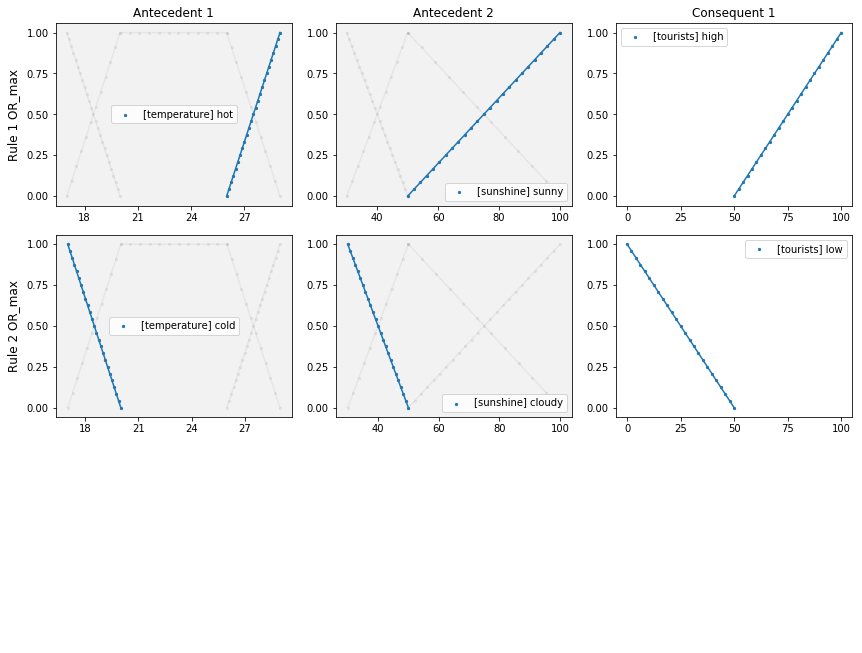

In [6]:
lv_temperature = LinguisticVariable(name="temperature", ling_values_dict={
    "cold": LinPWMF([17, 1], [20, 0]),
    "warm": LinPWMF([17, 0], [20, 1], [26, 1], [29, 0]),
    "hot": LinPWMF([26, 0], [29, 1])
})

lv_sunshine = LinguisticVariable(name="sunshine", ling_values_dict={
    "cloudy": LinPWMF([30, 1], [50, 0]),
    "part_sunny": TrapMF(p0=30, p1=50, p2=100),
    "sunny": LinPWMF([50, 0], [100, 1])
})

#lv_tourists = LinguisticVariable(name="tourists", ling_values_dict={
#    "low": LinPWMF([0, 1], [50, 0]),
#    "medium": TrapMF(p0=0, p1=50, p2=100),
#    "high": LinPWMF([50, 0], [100, 1])
#})

lv_tourists = ThreePointsLV("tourists", 0, 50, 100)

r1 = FuzzyRule(
    ants=[
        Antecedent(lv_temperature, "hot"),
        Antecedent(lv_sunshine, "sunny")
    ],
    ant_act_func=OR_max,
    cons=[
        Consequent(lv_tourists, "high")
    ],
    impl_func=MIN
)

r2 = FuzzyRule(
    ants=[
        Antecedent(lv_temperature, "cold"),
        Antecedent(lv_sunshine, "cloudy")
    ],
    ant_act_func=OR_max,
    cons=[
        Consequent(lv_tourists, "low"),
    ],
    impl_func=MIN
)

fis = FIS(
        aggr_func=np.max,
        defuzz_func=COA_func,
        rules=[r1, r2]
)

fisv = FISViewer(fis, figsize=(12, 10))
fisv.show()

**TODO student** 

* cite the interpretability mistake made in the FIS just above
* explain in plain english/french 2 possible fixes
* modify a copy of the FIS to fix the problem using 1 of your 2 propositions. Justify your choice.


## Other questions

**TODO student** Explain why having too many fuzzy rules is a bad idea (find an other reason that just say it is hard for a human to interpret the FIS).

**TODO student** Explain why this is a bad idea:

``` python 
lv_temperature =  LinguisticVariable(name="Temperature for rule 1", ling_values_dict={
    "cold": LinPWMF([-20, 1], [5, 0]),
    "warm": TrapMF(p0=0, p1=5, p2=15, p3=25),
    "hot": LinPWMF([15, 0], [35, 1])
})

lv_temperature_other =  LinguisticVariable(name="Temperature for rule 2", ling_values_dict={
    "cold": LinPWMF([-30, 1], [5, 0]),
    "warm": TrapMF(p0=0, p1=5, p2=15, p3=25),
    "hot": TrapMF(p0=15, p1=25, p2=35),
    "very hot": LinPWMF([25, 0], [35, 1])
})

r1 = FuzzyRule(ants=[
        Antecedent(lv_temperature, "cold"),
        # let's imagine that there are other antecedents..
    ],
    ant_act_func=OR_max,
    cons=[
       # let's imagine that there are consequents.
    ],
    impl_func=MIN)
r2 = FuzzyRule(ants=[
        Antecedent(lv_temperature_other, "warm"),
        # let's imagine that there are other antecedents..
    ],
    ant_act_func=OR_max,
    cons=[
       # let's imagine that there are consequents.
    ],
    impl_func=MIN)

# let's imagine the rest of the fis
```

-----------------

# Exercice - please answer below

**TODO student**: 

- Implement what is asked in the right folders
- Write the answer to the questions asked above. _For example_:

>In your opinion, what is the meaning of such a function?

blablabla

>Use `MembershipFunctionViewer` to demonstrate how well your implementation works with some relevant test cases/examples.

_add some plots here..._

In [7]:
#TODO student... 

### To submit

* Please make a zip called `lfa_labXX_YY.zip` where `XX` is the lab number and `YY` is your familly name. For example: `lfa_lab02_smith.zip`. 
* The mail's subject is `[LFA] rendu labXX` where `XX` is the lab number

The zip must contain all _needed_ the files to run this notebook. That is, don't send your virtualenv (only the requirements.txt). **If any additional steps are required to run your notebook(s)/code, please add a README.md where you indicate all the needed steps to reproduce your work.**

Note: Your notebooks must run completely even after the Jupyter kernel has been restarted. To ensure it will be the case when your lab will be reviewed, please select in the top menu "Kernel -> Restart and Run all" and check that the output of each cell is the desired output you want to submit.